In [135]:
'''
Classify material group based on its description given. It's a Text classification problem
From UI user will enter descirption of materials and the right material group should be suggested.
Reference: 
  TF-IDF: https://github.com/miguelfzafra/Latest-News-Classifier
  BoW/TF-IDF: https://towardsdatascience.com/multi-label-classification-using-bag-of-words-bow-and-tf-idf-4f95858740e5
'''
import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
sns.set() # use seaborn plotting style

In [136]:
def dataPreprocess(df, columnName):
    # \r and \n    
    df[columnName] = df[columnName].str.replace("\r", " ")
    df[columnName] = df[columnName].str.replace("\n", " ")
    df[columnName] = df[columnName].str.replace("    ", " ")
    df[columnName] = df[columnName].str.lower()
    
    punctuation_signs = list("?:!.,;")
    df[columnName] = df[columnName]

    for punct_sign in punctuation_signs:
        df[columnName] = df[columnName].str.replace(punct_sign, '')

def getDataUniqueValue(data):
    dataMap = {}
    count = 0
    for value in data:
        dataMap[count] = value
        count = count + 1
    return dataMap

def tfidfTransformer(ngram_range, max_df, min_df, max_features):
    tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
    return tfidf

In [137]:
materialsDF = pd.read_csv('Matgroup_Testdata.csv')
print(materialsDF.head())

#Convert columns to respctive type, here to string
materialsDF[['extsourcesystem', 'description', 'companycode', 'plant', 'materialgroup']] = materialsDF[['extsourcesystem', 'description', 'companycode', 'plant', 'materialgroup']].astype(str)
print(materialsDF.info())

  extsourcesystem                        description companycode plant  \
0         QI8_720   Trading Good,Reorder PointTG-D12        1110  1110   
1         QI8_720  Trading Good,Reorder PointTG-D112        2510  2510   
2         QI8_720  Trading Good,Reorder PointTG-D030        5410  5410   
3         QI8_720  Trading Good,Reorder PointTG-D020        2310  2310   
4         QI8_720                               1111        1110  1110   

  materialgroup  
0          L001  
1          L001  
2          L001  
3          L001  
4      QI8GRP01  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   extsourcesystem  432 non-null    object
 1   description      432 non-null    object
 2   companycode      432 non-null    object
 3   plant            432 non-null    object
 4   materialgroup    432 non-null    object
dtypes: object(5)
memory usa

In [138]:
# Combine all columns to one group
materialsDF["combined_description"] = materialsDF["extsourcesystem"] + " " + materialsDF["description"] + " " + materialsDF["companycode"] + " " + materialsDF["plant"] 
#materialsDF["combined_description"] = materialsDF["description"]
dataPreprocess(materialsDF, "combined_description")

# Convert to unicode
materialsDF["combined_description"] = materialsDF["combined_description"].astype('U')

X = materialsDF.combined_description
print("Combined features")
print(X.head())

Combined features
0    qi8_720 trading goodreorder pointtg-d12 1110 1110
1    qi8_720 trading goodreorder pointtg-d112 2510 ...
2    qi8_720 trading goodreorder pointtg-d030 5410 ...
3    qi8_720 trading goodreorder pointtg-d020 2310 ...
4                               qi8_720 1111 1110 1110
Name: combined_description, dtype: object


In [139]:
# Create unique codes for material groups
material_groupsMap = {}
print("Computing unique material groups")
material_groupsMap.update(getDataUniqueValue(materialsDF.materialgroup.unique().tolist()))
print(material_groupsMap)

# material group mapping
materialsDF['material_group_Code'] = materialsDF.materialgroup
materialsDF = materialsDF.replace({'material_group_Code':material_groupsMap})

Y = materialsDF.material_group_Code

Computing unique material groups
{0: 'L001', 1: 'QI8GRP01', 2: 'A001', 3: 'FIOMRP6', 4: '43000000', 5: 'YBMM00', 6: 'L002', 7: 'D001', 8: 'D008', 9: 'FIOMRP1', 10: 'P001', 11: 'E001', 12: 'FIOMRP5', 13: 'ZZPP01', 14: 'SLTQI8003', 15: 'FIOMRP4', 16: 'P002', 17: 'HUB001', 18: 'D007', 19: 'nan', 20: 'YBPM01', 21: 'FIOMRP3', 22: 'ZM_00001', 23: 'FIOMRP7', 24: 'YBMM01', 25: 'D009', 26: 'QI8GRP03', 27: 'QI8GRP02', 28: 'QI8MAT01'}


In [140]:
# Split training/testing data 
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
print("We have {} training samples".format(len(x_train)))
print("We have {} test samples".format(len(x_test)))
print("We have {} training target samples".format(len(y_train)))
print("We have {} test target samples".format(len(y_test)))

We have 345 training samples
We have 87 test samples
We have 345 training target samples
We have 87 test target samples


In [141]:
# Compute TF-IDF features

# Parameter selection
ngram_range = (1,5)
min_df = 1
max_df = 1.
max_features = 85 # Max features based on corpus length

# Create TF-IDF features
tfidf = tfidfTransformer(ngram_range, max_df, min_df, max_features)
features_train = tfidf.fit_transform(x_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(x_test).toarray()
labels_test = y_test
print(features_test.shape)

(345, 85)
(87, 85)


In [142]:
multiClassifer = MultinomialNB()
multiClassifer.fit(features_train, labels_train)
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, multiClassifer.predict(features_train))*100)

#multiClassifer._joint_log_likelihood(features_test)
mnbc_predicted = multiClassifer.predict(features_test)
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, mnbc_predicted)*100)
d = {
     'Model': 'Multinomial Naïve Bayes',
     'Training Set Accuracy': accuracy_score(labels_train, multiClassifer.predict(features_train))*100,
     'Test Set Accuracy': accuracy_score(labels_test, mnbc_predicted)*100
}

df_models_mnbc = pd.DataFrame(d, index=[0])
df_models_mnbc

The training accuracy is: 
71.8840579710145
The test accuracy is: 
60.91954022988506


,Model,Training Set Accuracy,Test Set Accuracy
0,Multinomial Naïve Bayes,71.884058,60.91954


In [143]:
# Classification report
print("Classification report")
print(classification_report(labels_test, mnbc_predicted))

Classification report
              precision    recall  f1-score   support

    43000000       0.00      0.00      0.00         1
        A001       0.35      0.78      0.48         9
        D007       0.00      0.00      0.00         4
        D009       0.00      0.00      0.00         1
        E001       0.00      0.00      0.00         1
     FIOMRP1       0.00      0.00      0.00         2
     FIOMRP4       0.00      0.00      0.00         3
     FIOMRP6       0.80      1.00      0.89         8
      HUB001       0.00      0.00      0.00         2
        L001       0.74      0.84      0.79        38
        L002       0.00      0.00      0.00         2
        P001       0.00      0.00      0.00         2
    QI8GRP01       0.43      0.86      0.57         7
    QI8GRP02       0.00      0.00      0.00         1
      YBMM00       0.00      0.00      0.00         2
      ZZPP01       0.00      0.00      0.00         2
         nan       0.00      0.00      0.00         2

    

c:\python36\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


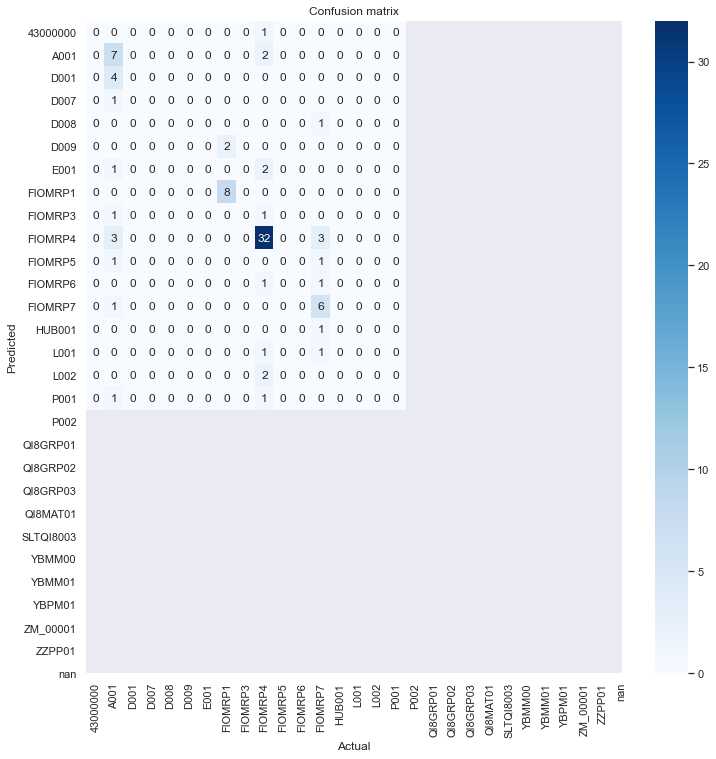

In [144]:
# Confusion matrix
aux_df = materialsDF[['materialgroup', 'material_group_Code']].drop_duplicates().sort_values('material_group_Code')
conf_matrix = confusion_matrix(labels_test, mnbc_predicted)
plt.figure(figsize=(12,12))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['materialgroup'].values, 
            yticklabels=aux_df['materialgroup'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [145]:
testDF = pd.read_csv('Matgroup_Testing.csv')
print(testDF.head())

#Convert columns to respctive type, here to string
testDF[['extsourcesystem', 'description', 'companycode', 'plant']] = testDF[['extsourcesystem', 'description', 'companycode', 'plant']].astype(str)

# Combine all columns to one group
testDF["combined_description"] = testDF["extsourcesystem"] + " " + testDF["description"] + " " + testDF["companycode"] + " " + testDF["plant"] 
#testDF["combined_description"] = testDF["description"]
# Preporcess of data
dataPreprocess(testDF, "combined_description")

# Convert to unicode
testDF["combined_description"] = testDF["combined_description"].astype('U')
print(testDF.info())

# Convert to tfidf vector
# Create TF-IDF features
# pickle tfidf and load during inference
test_Feature = tfidf.fit_transform(testDF.combined_description).toarray()
print(test_Feature.shape)

instance_predicted = multiClassifer.predict(test_Feature)
print("Instance predicted")
print(str(instance_predicted))

  extsourcesystem                       description  companycode plant
0         QI8_720  Trading Good,Reorder PointTG-D12         1110  1110
1         QI8_720                           Trading         1110  1110
2         QI8_720               Quickview Example 1         1010  FIO2
3         QI8_720                         Quickview         1010  FIO2
4         QI8_720       Blu-Ray Player AX-1000 (DE)         1010  1013
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   extsourcesystem       6 non-null      object
 1   description           6 non-null      object
 2   companycode           6 non-null      object
 3   plant                 6 non-null      object
 4   combined_description  6 non-null      object
dtypes: object(5)
memory usage: 368.0+ bytes
None
(6, 85)
Instance predicted
['L001' 'L001' 'FIOMRP6' 'A001' 'L001' 'FIOMRP6

In [156]:
# Try with SVM
from sklearn import svm
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

In [147]:
# Cross-Validation for Hyperparameter tuning
svc_0 =svm.SVC(random_state=8)

print('Parameters currently in use:\n')
pprint(svc_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [148]:
# Randomized search cross validation
# C
C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


In [151]:
# First create the base model to tune
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\python36\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    7.4s finished


RandomizedSearchCV(cv=3, estimator=SVC(random_state=8), n_iter=50,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True]},
                   random_state=8, scoring='accuracy', verbose=1)

In [152]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}

The mean accuracy of a model with these hyperparameters is:
0.6956521739130435


In [157]:
# Grid search cross validation
# Create the parameter grid based on the results of random search 
C = [.0001, .001, .01, .1]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]

# Create a base model
svc = svm.SVC(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    5.2s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=SVC(random_state=8),
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear'],
                          'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1], 'degree': [3, 4, 5],
                          'kernel': ['poly'], 'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1],
                          'gamma': [1, 10, 100], 'kernel': ['rbf'],
                          'probability': [True]}],
             scoring='accuracy', verbose=1)

In [158]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.1, 'kernel': 'linear', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.6900584795321638


In [159]:
best_svc = grid_search.best_estimator_
best_svc

SVC(C=0.1, kernel='linear', probability=True, random_state=8)

In [160]:
# Model fit and performance
best_svc.fit(features_train, labels_train)

SVC(C=0.1, kernel='linear', probability=True, random_state=8)

In [161]:
svc_pred = best_svc.predict(features_test)

In [162]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc.predict(features_train)))

The training accuracy is: 
0.6985507246376812


In [163]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))

The test accuracy is: 
0.632183908045977


In [164]:
# Classification report
print("Classification report")
print(classification_report(labels_test,svc_pred))

Classification report
              precision    recall  f1-score   support

    43000000       0.00      0.00      0.00         1
        A001       0.60      0.67      0.63         9
        D007       0.00      0.00      0.00         4
        D009       0.00      0.00      0.00         1
        E001       0.00      0.00      0.00         1
     FIOMRP1       0.00      0.00      0.00         2
     FIOMRP4       0.00      0.00      0.00         3
     FIOMRP6       0.80      1.00      0.89         8
      HUB001       0.00      0.00      0.00         2
        L001       0.65      0.92      0.76        38
        L002       0.00      0.00      0.00         2
        P001       0.00      0.00      0.00         2
    QI8GRP01       0.46      0.86      0.60         7
    QI8GRP02       0.00      0.00      0.00         1
      YBMM00       0.00      0.00      0.00         2
      ZZPP01       0.00      0.00      0.00         2
         nan       0.00      0.00      0.00         2

    

c:\python36\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


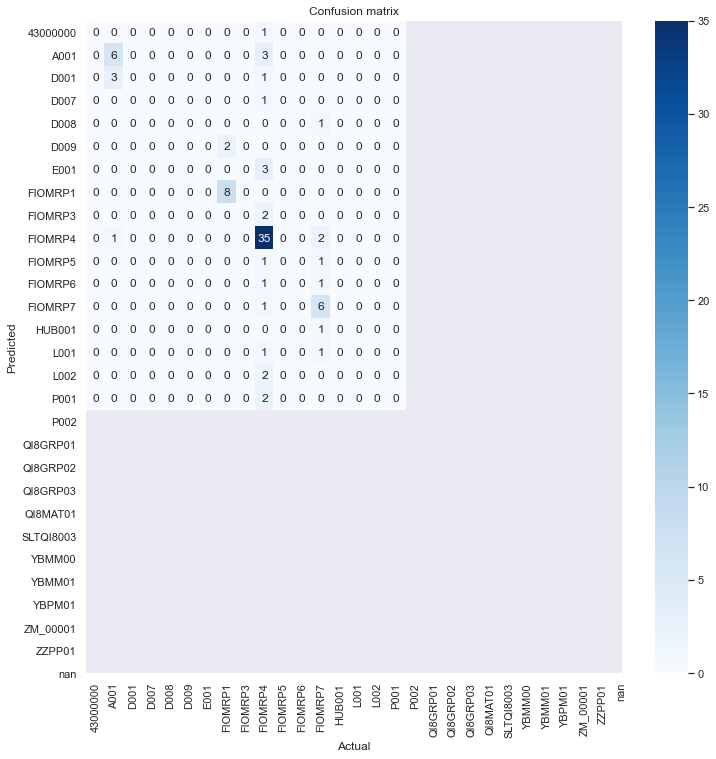

In [166]:
# Confusion matrix
aux_df = materialsDF[['materialgroup', 'material_group_Code']].drop_duplicates().sort_values('material_group_Code')
conf_matrix = confusion_matrix(labels_test, svc_pred)
plt.figure(figsize=(12,12))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['materialgroup'].values, 
            yticklabels=aux_df['materialgroup'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [171]:
# Base model
base_model = svm.SVC(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))*100

62.06896551724138

In [172]:
best_svc.fit(features_train, labels_train)
accuracy_score(labels_test, best_svc.predict(features_test))*100

63.2183908045977

In [173]:
d = {
     'Model': 'SVM',
     'Training Set Accuracy': accuracy_score(labels_train, best_svc.predict(features_train))*100,
     'Test Set Accuracy': accuracy_score(labels_test, svc_pred)*100
}

df_models_svc = pd.DataFrame(d, index=[0])
df_models_svc

,Model,Training Set Accuracy,Test Set Accuracy
0,SVM,69.855072,63.218391


In [170]:
# Test the model
instance_predicted = best_svc.predict(test_Feature)
print("Instance predicted")
print(str(instance_predicted))

Instance predicted
['L001' 'L001' 'FIOMRP6' 'L001' 'L001' 'L001']


In [174]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

In [175]:
knnc_0 =KNeighborsClassifier()

print('Parameters currently in use:\n')
pprint(knnc_0.get_params())

Parameters currently in use:

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


In [180]:
# Create the parameter grid 
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)]
print(n_neighbors)

param_grid = {'n_neighbors': n_neighbors}

# Create a base model
knnc = KNeighborsClassifier()

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 100]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.4s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49, 51, 53, 55, 57, 59, ...]},
             scoring='accuracy', verbose=1)

In [181]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 35}

The mean accuracy of a model with these hyperparameters is:
0.7192982456140351


In [182]:
n_neighbors = [1,2,3,4,5,6,7,8,9,10,11]
param_grid = {'n_neighbors': n_neighbors}

knnc = KNeighborsClassifier()
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    0.2s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
             scoring='accuracy', verbose=1)

In [183]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 10}

The mean accuracy of a model with these hyperparameters is:
0.7134502923976608


In [184]:
best_knnc = grid_search.best_estimator_
best_knnc

KNeighborsClassifier(n_neighbors=10)

In [185]:
# Model fit and performance
best_knnc.fit(features_train, labels_train)

KNeighborsClassifier(n_neighbors=10)

In [186]:
knnc_pred = best_knnc.predict(features_test)

In [222]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_knnc.predict(features_train))*100)

The training accuracy is: 
71.59420289855073


In [223]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, knnc_pred)*100)

The test accuracy is: 
59.77011494252874


In [189]:
# Classification report
print("Classification report")
print(classification_report(labels_test,knnc_pred))

Classification report
              precision    recall  f1-score   support

    43000000       0.00      0.00      0.00         1
        A001       0.37      0.78      0.50         9
        D007       0.00      0.00      0.00         4
        D009       0.00      0.00      0.00         1
        E001       0.00      0.00      0.00         1
     FIOMRP1       0.00      0.00      0.00         2
     FIOMRP4       0.00      0.00      0.00         3
     FIOMRP6       0.80      1.00      0.89         8
      HUB001       0.00      0.00      0.00         2
        L001       0.70      0.82      0.76        38
        L002       0.00      0.00      0.00         2
        P001       0.00      0.00      0.00         2
    QI8GRP01       0.46      0.86      0.60         7
    QI8GRP02       0.00      0.00      0.00         1
      YBMM00       0.00      0.00      0.00         2
      ZZPP01       0.00      0.00      0.00         2
         nan       0.00      0.00      0.00         2

    

c:\python36\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


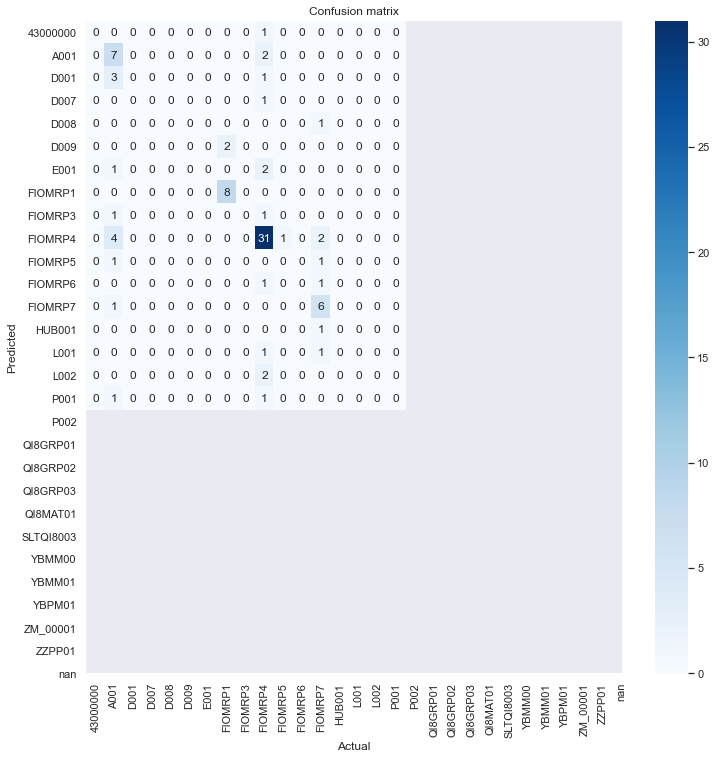

In [191]:
aux_df = materialsDF[['materialgroup', 'material_group_Code']].drop_duplicates().sort_values('material_group_Code')
conf_matrix = confusion_matrix(labels_test, knnc_pred)
plt.figure(figsize=(12,12))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['materialgroup'].values, 
            yticklabels=aux_df['materialgroup'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [220]:
base_model = KNeighborsClassifier()
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))*100

60.91954022988506

In [221]:
best_knnc.fit(features_train, labels_train)
accuracy_score(labels_test, best_knnc.predict(features_test))*100
# We can see that the default model (with 5 Nearest Neighbors) performs better.

59.77011494252874

In [219]:
d = {
     'Model': 'KNN',
     'Training Set Accuracy': accuracy_score(labels_train, best_knnc.predict(features_train))*100,
     'Test Set Accuracy': accuracy_score(labels_test, knnc_pred)*100
}

df_models_knnc = pd.DataFrame(d, index=[0])
df_models_knnc

,Model,Training Set Accuracy,Test Set Accuracy
0,KNN,71.594203,59.770115


In [196]:
# Multinomial Logistic Regression
from sklearn.linear_model import LogisticRegression

In [197]:
lr_0 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
pprint(lr_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [198]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['multinomial']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

pprint(random_grid)

{'C': [0.1,
       0.2,
       0.30000000000000004,
       0.4,
       0.5,
       0.6,
       0.7000000000000001,
       0.8,
       0.9,
       1.0],
 'class_weight': ['balanced', None],
 'multi_class': ['multinomial'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


In [199]:
# First create the base model to tune
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\python36\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached

RandomizedSearchCV(cv=3, estimator=LogisticRegression(random_state=8),
                   n_iter=50,
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0],
                                        'class_weight': ['balanced', None],
                                        'multi_class': ['multinomial'],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'sag', 'saga',
                                                   'lbfgs']},
                   random_state=8, scoring='accuracy', verbose=1)

In [200]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'saga', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': None, 'C': 1.0}

The mean accuracy of a model with these hyperparameters is:
0.7072463768115943


In [201]:
# Grid Search Cross Validation
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['sag']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which mean

GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=LogisticRegression(random_state=8),
             param_grid={'C': [0.6, 0.6444444444444444, 0.6888888888888889,
                               0.7333333333333333, 0.7777777777777778,
                               0.8222222222222222, 0.8666666666666667,
                               0.9111111111111111, 0.9555555555555555, 1.0],
                         'class_weight': ['balanced'],
                         'multi_class': ['multinomial'], 'penalty': ['l2'],
                         'solver': ['sag']},
             scoring='accuracy', verbose=1)

In [202]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.8222222222222222, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}

The mean accuracy of a model with these hyperparameters is:
0.5701754385964912


In [203]:
best_lrc = grid_search.best_estimator_
best_lrc

LogisticRegression(C=0.8222222222222222, class_weight='balanced',
                   multi_class='multinomial', random_state=8, solver='sag')

In [204]:
best_lrc.fit(features_train, labels_train)

c:\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.8222222222222222, class_weight='balanced',
                   multi_class='multinomial', random_state=8, solver='sag')

In [205]:
lrc_pred = best_lrc.predict(features_test)

In [217]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train))*100)

The training accuracy is: 
63.76811594202898


In [218]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred)*100)

The test accuracy is: 
42.5287356321839


In [208]:
# Classification report
print("Classification report")
print(classification_report(labels_test,lrc_pred))

Classification report
              precision    recall  f1-score   support

    43000000       0.00      0.00      0.00         1
        A001       0.33      0.11      0.17         9
        D007       0.00      0.00      0.00         4
        D009       0.00      0.00      0.00         1
        E001       0.00      0.00      0.00         1
     FIOMRP1       0.00      0.00      0.00         2
     FIOMRP4       0.50      0.33      0.40         3
     FIOMRP5       0.00      0.00      0.00         0
     FIOMRP6       0.67      0.50      0.57         8
      HUB001       0.00      0.00      0.00         2
        L001       1.00      0.66      0.79        38
        L002       0.00      0.00      0.00         2
        P001       0.00      0.00      0.00         2
    QI8GRP01       0.46      0.86      0.60         7
    QI8GRP02       0.00      0.00      0.00         1
   SLTQI8003       0.00      0.00      0.00         0
      YBMM00       0.00      0.00      0.00         2
     

c:\python36\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python36\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


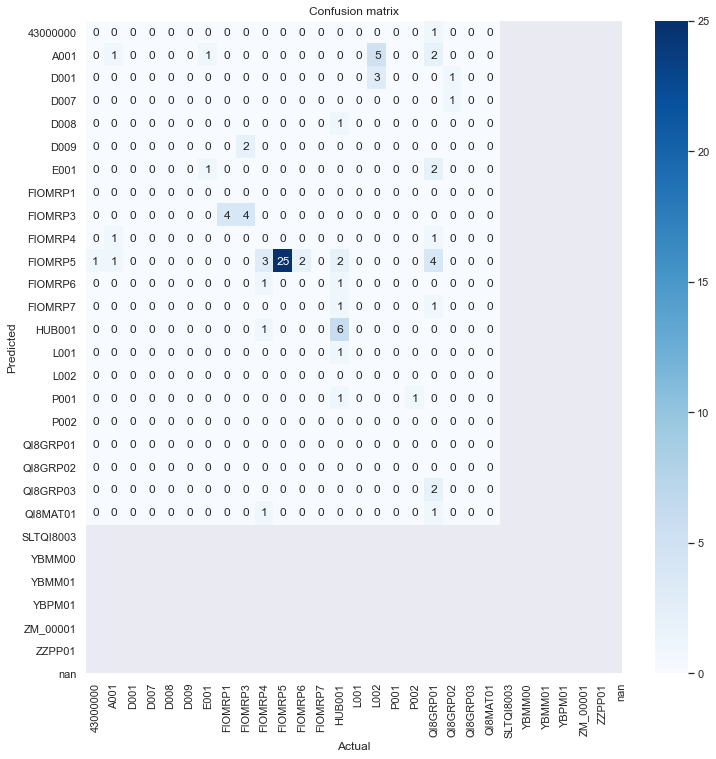

In [209]:
aux_df = materialsDF[['materialgroup', 'material_group_Code']].drop_duplicates().sort_values('material_group_Code')
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(12,12))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['materialgroup'].values, 
            yticklabels=aux_df['materialgroup'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [214]:
base_model = LogisticRegression(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))*100

59.77011494252874

In [215]:
best_lrc.fit(features_train, labels_train)
accuracy_score(labels_test, best_lrc.predict(features_test))*100

c:\python36\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


42.5287356321839

In [213]:
d = {
     'Model': 'Logistic Regression',
     'Training Set Accuracy': accuracy_score(labels_train, best_lrc.predict(features_train))*100,
     'Test Set Accuracy': accuracy_score(labels_test, lrc_pred)*100
}

df_models_lrc = pd.DataFrame(d, index=[0])
df_models_lrc

,Model,Training Set Accuracy,Test Set Accuracy
0,Logistic Regression,63.768116,42.528736


In [225]:
# Best model selection
df_summary = pd.DataFrame()
df_summary = df_summary.append(df_models_mnbc)
df_summary = df_summary.append(df_models_svc)
df_summary = df_summary.append(df_models_knnc)
df_summary = df_summary.append(df_models_lrc)
df_summary = df_summary.reset_index().drop('index', axis=1)
df_summary

,Model,Training Set Accuracy,Test Set Accuracy
0,Multinomial Naïve Bayes,71.884058,60.919540
1,SVM,69.855072,63.218391
2,KNN,71.594203,59.770115
3,Logistic Regression,63.768116,42.528736


In [226]:
df_summary.sort_values('Test Set Accuracy', ascending=False)

,Model,Training Set Accuracy,Test Set Accuracy
1,SVM,69.855072,63.218391
0,Multinomial Naïve Bayes,71.884058,60.919540
2,KNN,71.594203,59.770115
3,Logistic Regression,63.768116,42.528736


In [ ]:
'''
Issues with the data set:
    1. Data collection is skewed, some classes have only one or two samples
    2. Data is imbalanced, all class labels must have equal propotion of samples
    3. Data cleanup is required, empty description or 1 or 2 character descriptions are noise
    4. Tried with TF-IDF, we can use other metrics such as BoW.
    5. Data columns such as extsourcesystem, companycode and plant all are same and doesn't contribute much for target variable 'materialgroup'
    6. Identify right set of other features which contributes material group
'''